# Assignment 1 | Classification

## Group F:
### Almpes Kotzai: 201968817 
### Roberto Plaza: 201953526
### Constantinos Economides: 201984019
### Andreas Neofytou: 201963027


## Table of contents

1. [Introduction](#Introduction)

2. [The problem domain](#The-problem-domain)

3. [Data processing](#Data-processing)
    
    - [Loading modules](#Loading-modules)
    
    - [Loading data](#Loading-data)
    
    - [Data handling](#Data-handling)
    
    - [Correlation and feature engineering](#Correlation-and-feature-engineering)
    
    - [One-hot encoding](#One-hot-encoding)
    
    - [Train-test split](#Train-test-split) 

4. [Classification](#Classification)
    
    - [Naive bayes](#Naive-bayes)
    - [Random Classification Average solution](#Random-Classification-Average-solution)
    - [Random Forest Classifier](#Random-Forest-Classifier)
    - [Logistic Regression](#Logistic-Regression)
    - [Support Vector Classifier](#Support-Vector-Classifier)
    - [Ensembles](#Ensembles)

5 . [Kaggle score | Conclusion](#Kaggle-score-|-Conclusion)
    
 [Required libraries](#Required-libraries)
 
 [References](#Required-libraries)
 
 

## Introduction

[[ go back to the top ]](#Table-of-contents)

In this notebook we present a step by step process on trying to solve the classification problem for the course CS985: Machine Learning for Data Analytics being 1/2 of the marks for the first assignment.

First we go through the data handling/cleaning, one-hot encoding, and generating the appropriate shapes for the X, y train and target datasets from train we use a the standard workflow to input the data and use $R^2$ score mostly along with mean squared error for chosen models. 

## The problem domain
[[ go back to the top ]](#Table-of-contents)

Our task for this part of the class assignment is to build a model to predict the genre of a song. The data provided is drawn from [Nicolas Carbone's <i>Spotify Past Decades Songs Attributes
Spotify attributes of songs from all available past decades (50s - 10s)</i>](https://www.kaggle.com/cnic92/spotify-past-decades-songs-50s10s) 

The challenge is to build a good machine learning model that is able to predict the genre of a song. Popularity is a category value so we are treating this as a classification problem. 


## Data processing
[[ go back to the top ]](#Table-of-contents)

### Loading modules
[[ go back to the top ]](#Table-of-contents)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from numpy import array
from numpy import argmax
import matplotlib.pyplot as plt
import time
import os
import types

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.neighbors import KNeighborsClassifier



from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score



from sklearn.model_selection import GridSearchCV


from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import random


#For ignoring warnings
import warnings
warnings.filterwarnings('ignore')

### Loading Data
[[ go back to the top ]](#Table-of-contents)

In [2]:
def load_data(path):
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            full_path = os.path.join(dirname, filename)
            print(full_path)
            if "Test" in filename:
                test = pd.read_csv(full_path)
            else:
                train = pd.read_csv(full_path)
                
    return train, test
train, test = load_data('./cs98x-spotify-classification')

./cs98x-spotify-classification/CS98XClassificationTrain.csv
./cs98x-spotify-classification/CS98XClassificationTest.csv


Checking the data 

In [3]:
train.head(5)

,Id,title,artist,year,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop,top genre
0,1,My Happiness,Connie Francis,1996,107,31,45,-8,13,28,150,75,3,44,adult standards
1,2,Unchained Melody,The Teddy Bears,2011,114,44,53,-8,13,47,139,49,3,37,NaN
2,3,How Deep Is Your Love,Bee Gees,1979,105,36,63,-9,13,67,245,11,3,77,adult standards
3,4,Woman in Love,Barbra Streisand,1980,170,28,47,-16,13,33,232,25,3,67,adult standards
4,5,Goodbye Yellow Brick Road - Remastered 2014,Elton John,1973,121,47,56,-8,15,40,193,45,3,63,glam rock


### Data Handling
[[ go back to the top ]](#Table-of-contents)

Combining train and test by stacking them one
after the other, this is done with keys so we can
de-select them correctly at the end. 

In [4]:
# merge train and test 
sel_data = pd.concat([train, test], keys=[0,1])

unique_labels = sel_data['top genre'].nunique()
print(unique_labels)

86


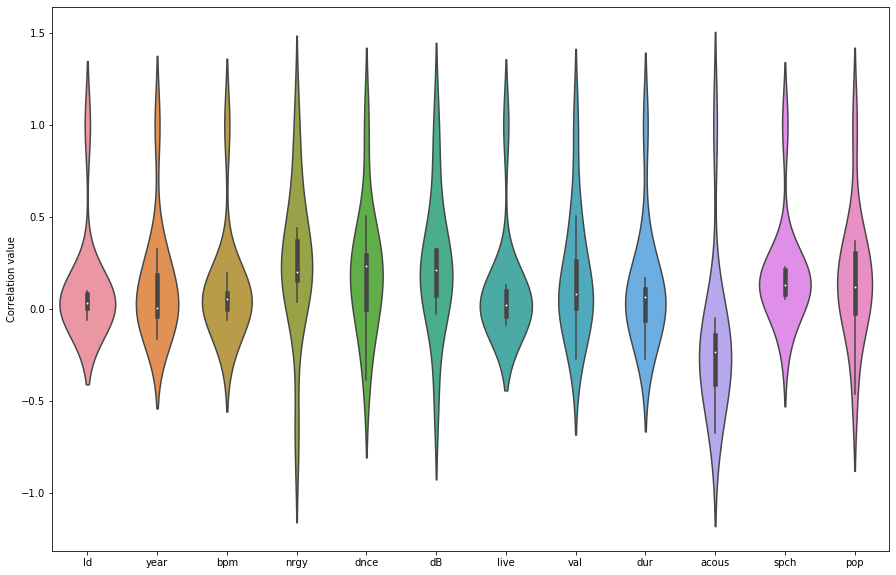

In [5]:
# white dot shows median
# interquartile range (black bar in center of violin)
# upper adjacent value desribes third quartile
# lower adjecent value describes first quartile
# observations lying outside of the quartiles can be considered outliers

corr = sel_data.corr()
plt.figure(figsize=(15,10))
plt.ylabel("Correlation value")
sns.violinplot(data=corr)
plt.show()

Shows the weight of each genre from the train set. It shows that there are three main genres in the train set. Those are
"adult standards", "Album rock" and "Dance pop" that occupy a total of 45% of the songs enlisted in the dataframe.

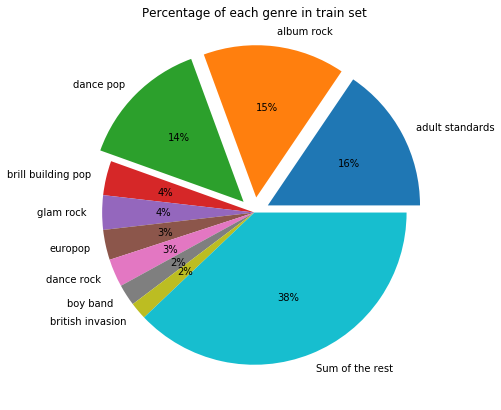

In [6]:
data10 = train["top genre"].value_counts()[:9].values.tolist()
sumofrest = sum(train["top genre"].value_counts()[9:])
data10.append(sumofrest)

explode = (0.1,0.1,0.1,0,0,0,0,0,0,0)
labels = train["top genre"].value_counts()[:9].index.tolist()
labels.append("Sum of the rest")

plt.figure(figsize=(12,7))
plt.title("Percentage of each genre in train set")
plt.pie(data10, labels=labels, explode=explode, autopct='%1.0f%%')
plt.show()

Checking the combined dataset

In [7]:
sel_data.head(5)

Id                                        title            artist  year  \
0 0   1                                 My Happiness    Connie Francis  1996   
  1   2                             Unchained Melody   The Teddy Bears  2011   
  2   3                        How Deep Is Your Love          Bee Gees  1979   
  3   4                                Woman in Love  Barbra Streisand  1980   
  4   5  Goodbye Yellow Brick Road - Remastered 2014        Elton John  1973   

     bpm  nrgy  dnce  dB  live  val  dur  acous  spch  pop        top genre  
0 0  107    31    45  -8    13   28  150     75     3   44  adult standards  
  1  114    44    53  -8    13   47  139     49     3   37              NaN  
  2  105    36    63  -9    13   67  245     11     3   77  adult standards  
  3  170    28    47 -16    13   33  232     25     3   67  adult standards  
  4  121    47    56  -8    15   40  193     45     3   63        glam rock

Show representation of genre

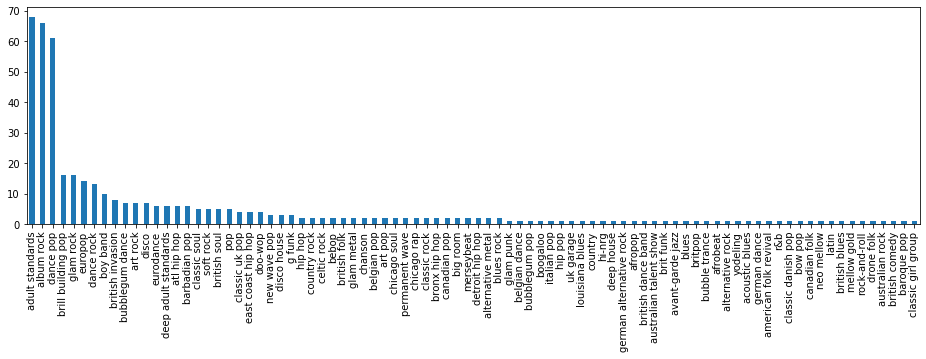

In [8]:

import matplotlib.pyplot as plt
plt.figure(figsize=(16, 4))
train["top genre"].value_counts().plot(kind='bar')
#train["top genre"].value_counts()

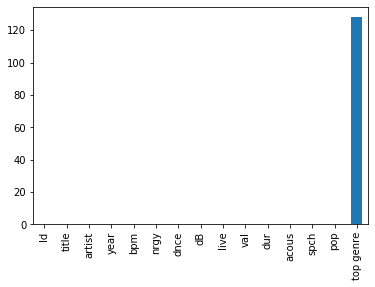

In [9]:
# check what values are null/nan's
sel_data.isnull().sum().plot(kind='bar')

Just top genre has null values so we are going to delete all of them. In this case, the quantity is bigger because in that file we are combining train and test (Test don't have that values).


In [10]:
sel_data['top genre'].fillna("adult standards", inplace=True)
sel_data.drop(columns=["Id"], inplace=True)
# check if changes went through
sel_data.isnull().sum()

title        0
artist       0
year         0
bpm          0
nrgy         0
dnce         0
dB           0
live         0
val          0
dur          0
acous        0
spch         0
pop          0
top genre    0
dtype: int64

### Correlation and feature engineering
[[ go back to the top ]](#Table-of-contents)

Next we check for correlations for the given features, to see if we can find anything interesting or how to proceeding on simple feature engineering or feature selection.

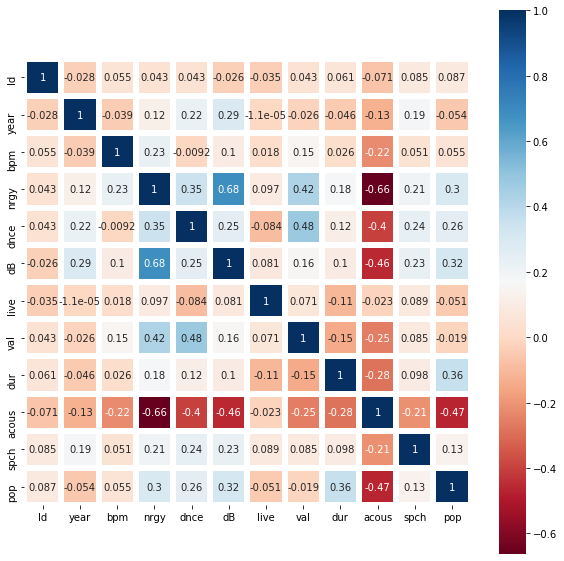

In [11]:
# With the correlation is easy to see witch variables are relationated and the influence of them.
corr = train.corr()

fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches

colormap = plt.cm.RdBu
sns.heatmap(train.corr(),linewidths=5,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True,ax=ax)

In [12]:
sel_data['(dB+bpm)/dur'] = (sel_data['dB'] + sel_data['bpm'])/sel_data['dur'] 
sel_data['log(dur+dB+nrgy)'] = np.log(sel_data['dur'] + sel_data['dB'] + sel_data['nrgy'])
sel_data['log(dur+dB+nrgy+dnce)'] = np.log(sel_data['dur'] + sel_data['dB'] + sel_data['nrgy'] + sel_data['dnce'])

### One-hot encoding 
[[ go back to the top ]](#Table-of-contents)

Using also 'drop_first=True' as this according to theory and we saw in practise as well working on both regression and classification helps with the overall increase in the score metrics respectively when applying the method 'get_dummies()'.

In [13]:
sel_data = pd.get_dummies(sel_data, columns=["artist", "title"], drop_first=True)

In [14]:
sel_data.head()

year  bpm  nrgy  dnce  dB  live  val  dur  acous  spch  ...  \
0 0  1996  107    31    45  -8    13   28  150     75     3  ...   
  1  2011  114    44    53  -8    13   47  139     49     3  ...   
  2  1979  105    36    63  -9    13   67  245     11     3  ...   
  3  1980  170    28    47 -16    13   33  232     25     3  ...   
  4  1973  121    47    56  -8    15   40  193     45     3  ...   

     title_You Give Love A Bad Name title_You Keep Me Hangin On  \
0 0                               0                           0   
  1                               0                           0   
  2                               0                           0   
  3                               0                           0   
  4                               0                           0   

     title_You Make Me Feel Like Dancing  title_You Mean Everything to Me  \
0 0                                    0                                0   
  1                                    0                                0   
  2                                    0                                0   
  3                                    0                                0   
  4                                    0                                0   

     title_You To Me Are Everything  title_You'll Never Walk Alone  \
0 0                               0                              0   
  1                               0                              0   
  2                               0                              0   
  3                               0                              0   
  4                               0                              0   

     title_You're The One That I Want - From â€œGreaseâ€  title_Young Girl  \
0 0                                                  0                    0   
  1                                                  0                    0   
  2                                                  0                    0   
  3                                                  0                    0   
  4                                                  0                    0   

     title_Your Song  title_Zulu Nation Throw Down  
0 0                0                             0  
  1                0                             0  
  2                0                             0  
  3                0                             0  
  4                0                             0  

[5 rows x 982 columns]

### Train-test split
[[ go back to the top ]](#Table-of-contents)

Using the carefully but simple approach of keeping key-value pairs for the train-test merge, we can now safely eject the train and test sets, into the Xtrain and Xtest which are one-hot encoded versions of them. Care is taken to delete the 'pop' category copy from the enhanced test set so we do not get overfiting and leaking information to the score evaluation.

In [15]:
Xtrain = sel_data.xs(0)
Xtest = sel_data.xs(1)
# delete 'top genre' copy from one-hot encoded test set
Xtest.drop(columns=["top genre"], inplace=True)
# print the shapes
print(Xtrain.shape)
print(Xtest.shape)


(453, 982)
(113, 981)


We split the Xtrain further to X data matrix and y target series and then we split the X, y to further X_train, X_test, y_train, y_test so we have the universal format of the data to be processed correctly by sci-kit learn's machine learning classes/objects and to extend their configurability for every model available in the library.

This also enables us to verify the accuracy of our models rather than using all the train data to get a higher score without realising the generalisation the model is doing and is good practise in general. This means we get less data to train ( 453 rows ) and as the <i> no free lunch theorem </i> states, this might affect our models performances because it has been proven over and over again that with more data, either synthetic generation, expert labelling or other methods, every machine learning model can actually increase in accuracy rapidly. However, we do this as we mentioned that it makes data analysis easier, and it helps with accuracy metrics substantially.

In [16]:
# split Xtrain to X, y 
X = Xtrain.loc[:, Xtrain.columns!='top genre']
y = Xtrain.loc[:, 'top genre']


scaler = StandardScaler()

X = pd.DataFrame(scaler.fit_transform(X), 
                 X.index, X.columns)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42)

Xtest = pd.DataFrame(scaler.transform(Xtest),
                    Xtest.index, 
                    Xtest.columns)


## Classification
[[ go back to the top ]](#Table-of-contents)

A variety of models were created to try and predict the genre of songs in the test data set. Below only the five best models will be implemented.

 Some of the other models used were Multinomial Naïve Bayes, Stochastic Gradient Descent and Decision tree. These models produced low results thus they were excluded.
 
Gaussian Naïve Bayes along with a random model were used as benchmark. From there we could compare other model’s performance. Random, as the name suggests, gave random results which (unfortunately for us) none of them was any good. Gaussian Model was simple to build with an accuracy of 0.28 which we then tried to improve. 
The best model that we came up with was logistic regression using the Standard Scaler. Several different scalers were considered such as MinMax, MaxAbs and PowerTransformer scalers but StandardScaler outperformed them. 
 Below we show that we also tried random forest. At first decision tree was used but using random forest almost doubled the accuracy of the model therefore the implementation of decision tree was excluded. 



In [17]:
# creating a dictionary to save the time taken for each model
# the R^2 scores for each model
# and the RMSE for each model indluding ensemble
# lr: LinearRegression, xgb: XGBRegressor, xgbrgr: Bagging Regressor with XGBReggressor
# ada : AdaBoostRegressor, rf: Random Forest Regresssor, rd: Ridge, ens: Ensemble model
models = {}
values = {}

time_taken = dict(zip(models, values))
scores = dict(zip(models, values))


### Naive bayes
[[ go back to the top ]](#Table-of-contents)

This is our benchmark

In [18]:
start = time.time()
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)

end = time.time()
difference = end - start
time_taken['nb'] = round(difference, 4)
scores['nb'] = accuracy_score(y_test, y_pred)
print("Time taken: {0:4f} (s)".format(difference))
print("NB score: {0}".format(accuracy_score(y_test, y_pred)))
y_pred = gnb.predict(Xtest)


Time taken: 0.073859 (s)
NB score: 0.2857142857142857


### Random Classification Average solution
[[ go back to the top ]](#Table-of-contents)

In [19]:
#Random Classification Average solution
start = time.time()
counter=len(y_train)
y_pred = []
    
random_train = train
random_train = random_train.dropna()
list_genre=random_train["top genre"].unique()

number_iterations = 10
average_score  = 0
for y in range (1,number_iterations):
    score = 0
    for x in y_test:    
        random_value = random.choice(list_genre)
        if  x == random_value:
            score = score +1
    score = score /counter
    average_score = average_score + score
average_score = average_score / number_iterations

end = time.time()
time_taken['random'] = round(difference, 4)
scores['random'] = average_score
print("Time taken: {0:4f} (s)".format(difference))
print("random score: {0}".format(average_score))


Time taken: 0.073859 (s)
random score: 0.0033149171270718232


### Random Forest Classifier
[[ go back to the top ]](#Table-of-contents)

In [20]:
# n_estimators set to default to 100
# max_depth = 5 so it does not overfit
rf = RandomForestClassifier( max_depth=5, random_state=42)
start = time.time()
rf.fit(X_train, y_train)
end = time.time()
difference = end - start
score = rf.score(X_test, y_test)
y_pred = rf.predict(X_test)
time_taken['rf'] = round(difference, 4)
scores['rf'] = score

print("Time taken: {0:4f} (s)".format(difference))
print("rf score: {0}".format(score))


Time taken: 0.176455 (s)
rf score: 0.4065934065934066


### Logistic Regression
[[ go back to the top ]](#Table-of-contents)

Similar form to linear regression but aims to predict the probability of a set of outcomes mapping to a class or category. 

In [21]:
start = time.time()
# For better results put max_iter = 1000
lr = LogisticRegression(multi_class="multinomial",solver="saga",random_state=42, max_iter=100)
lr.fit(X_train, y_train)

end = time.time()
difference = end - start

score = lr.score(X_test, y_test)
y_pred = lr.predict(X_test)

time_taken['lr'] = round(difference, 4)
scores['lr'] = score

print("Time taken: {0:4f} (s)".format(difference))
print("lr score: {0}".format(score))


Time taken: 35.480672 (s)
lr score: 0.6043956043956044


### Support Vector Classifier
[[ go back to the top ]](#Table-of-contents)

Support Vector Machines: Good for linear and nonlinear classification. Well suited for small sized dataset.

In [22]:
from sklearn.svm import SVC
start = time.time()

svc = SVC(decision_function_shape='ovo', random_state=42,kernel='linear')
svc.fit(X_train, y_train)

end = time.time()
difference = end - start

score = svc.score(X_test, y_test)
y_pred = svc.predict(X_test)

time_taken['svc'] = round(difference, 4)
scores['svc'] = score

print("Time taken: {0:4f} (s)".format(difference))
print("svc score: {0}".format(score))



Time taken: 1.101146 (s)
svc score: 0.46153846153846156


### Ensembles
[[ go back to the top ]](#Table-of-contents)

In [23]:
start = time.time()
voting_clf = VotingClassifier(estimators=[('rf', rf),('lr', lr), ('svc', svc)], voting='hard')
voting_clf.fit(X_train, y_train)
#Then look at the accuracy scores from the individual and combined classifiers
for clf in (rf,lr,svc,voting_clf):
    clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(clf.__class__.__name__, accuracy_score(y_test, y_pred))
y_pred = clf.predict(Xtest)

end = time.time()
difference = end - start

time_taken['vo'] = round(difference, 4)
scores['vo'] = score

print("Time taken: {0:4f} (s)".format(difference))
print("kn score: {0}".format(score))


VotingClassifier 0.4835164835164835
Time taken: 111.031683 (s)
kn score: 0.46153846153846156


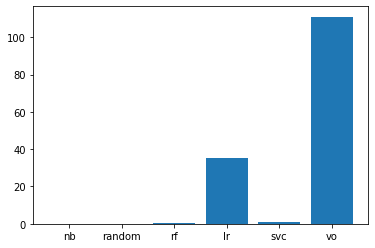

In [24]:
def plot_dict(dictionary):
    plt.bar(range(len(dictionary)), list(dictionary.values()), align='center')
    plt.xticks(range(len(dictionary)), list(dictionary.keys()))

plot_dict(time_taken)

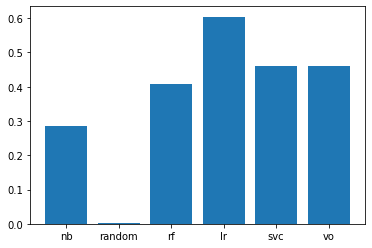

In [25]:
plot_dict(scores)

## Kaggle score | Conclusion

[[ go back to the top ]](#Table-of-contents)

After working with the different number of machine learning model we found out that the smallest tweak can make a difference either to get a better result or end up with overfitting. At the end we ended up with a Kaggle score of 0.55357 by using the logistic regression model which we are satisfied with and the little difference due to not generalising perfectly from an offline score of 0.57~  that we have for it. 

We tried to push it a little bit by changing the parameters or using different scalers, but we ended up with overfit and therefore did not manage to increase the score. 

Overall this was a good experience to be part of. We gained experience in using Classifier models and how to change their parameters based on the type of the problem. The pre-processing stage also has a major impact as, in this case we had a small amount of data to work with. We managed to generate more data from the existing ones, which at the end helped us to improve the accuracy of our mode.  


## Required libraries
[[ go back to the top ]](#Table-of-contents)

[based on this solution](https://stackoverflow.com/questions/40428931/package-for-listing-version-of-packages-used-in-a-jupyter-notebook#40429176)

In [26]:
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages are weird and have different
        # imported names vs. system/pip names. Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name. You'll have to had
        # exceptions to this list manually!
        poorly_named_packages = {
            "PIL": "Pillow",
            "sklearn": "scikit-learn"
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name
imports = list(set(get_imports()))

# The only way I found to get the version of the root package
# from only the name of the package is to cross-check the names 
# of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

for r in requirements:
    print("{}=={}".format(*r))

NameError: name 'pkg_resources' is not defined

## References

1. VanderPlas J. Python data science handbook: Essential tools for working with data. " O'Reilly Media, Inc."; 2016 Nov 21.

2. Géron A. Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems. O'Reilly Media; 2019 Sep 5.

3. Müller AC, Guido S. Introduction to machine learning with Python: a guide for data scientists. " O'Reilly Media, Inc."; 2016 Sep 26.